In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize 
from data_retriever import read_tickers
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

### Format Data

In [3]:
# read in data
tickers1 = ['AAPL', 'AMZN', 'GOOGL', 'FB','NFLX','TSLA']
df1 = pd.DataFrame()

for symbol in tickers1:
    try:
        adj_close = pd.read_csv(f'data/time_series_daily_curated/{symbol}.csv', index_col=0).loc['5. adjusted close',:]
        adj_close.name = symbol
        df1 = df1.append(adj_close)
    except:
        continue
        
df1 = df1.transpose()

# convert index to datetime
df1.index = pd.to_datetime(df1.index, infer_datetime_format=True)
df1_train = df1.loc['2016-01-01':'2018-12-31']
df1_test = df1.loc['2019-01-01':'2019-12-31']

df1_train

,AAPL,AMZN,GOOGL,FB,NFLX,TSLA
2016-01-04,24.320249,636.99,759.44,102.22,109.960,44.682
2016-01-05,23.710800,633.79,761.53,102.73,107.660,44.686
2016-01-06,23.246788,632.65,759.33,102.97,117.680,43.808
2016-01-07,22.265667,607.94,741.00,97.92,114.560,43.130
2016-01-08,22.383401,607.05,730.91,97.33,111.390,42.200
...,...,...,...,...,...,...
2018-12-24,35.738300,1343.96,984.67,124.06,233.880,59.078
2018-12-26,38.255048,1470.90,1047.85,134.18,253.670,65.218
2018-12-27,38.006781,1461.64,1052.90,134.52,255.565,63.226
2018-12-28,38.026253,1478.02,1046.68,133.20,256.080,66.774


In [4]:
# read in data
tickers2 = ['IGV','SPY','QQQ','IWM','DIA','XLE','XLP']
df2 = pd.DataFrame()

for symbol in tickers2:
    try:
        adj_close = pd.read_csv(f'data/time_series_daily_curated/{symbol}.csv', index_col=0).loc['5. adjusted close',:]
        adj_close.name = symbol
        df2 = df2.append(adj_close)
    except:
        continue
        
df2 = df2.transpose()

# convert index to datetime
df2.index = pd.to_datetime(df2.index, infer_datetime_format=True)
df2_train = df2.loc['2016-01-01':'2018-12-31']
df2_test = df2.loc['2019-01-01':'2019-12-31']

df2_train

,IGV,SPY,QQQ,IWM,DIA,XLE,XLP
2016-01-04,99.820045,181.835178,104.656743,102.545867,152.484426,47.906996,43.283997
2016-01-05,99.751285,182.142727,104.475146,102.769583,152.573448,48.089726,43.561848
2016-01-06,98.572540,179.845143,103.471589,101.203571,150.392428,46.238593,43.414239
2016-01-07,96.048061,175.530376,100.231530,98.500334,146.849384,45.110435,42.893269
2016-01-08,94.888962,173.603653,99.409569,96.803821,145.318219,44.530466,42.563320
...,...,...,...,...,...,...,...
2018-12-24,158.195582,224.955183,141.145844,122.237621,207.840541,46.685353,45.870790
2018-12-26,168.500804,236.321016,149.958853,128.112562,217.951445,49.590181,47.150992
2018-12-27,171.034874,238.135325,150.539174,128.646647,220.381492,49.850315,47.602828
2018-12-28,170.756623,237.828141,150.460486,129.015652,219.638184,49.468785,47.602828


### Analysis & Metrics

In [5]:
RISK_FREE_RATE = 0.0162 # current risk free rate
NUM_TRADING_DAYS = 250


# returns expected_returns and cov_matrix
def extract_info(df):
    returns = df.pct_change().mean()
    cov = df.pct_change().apply(lambda x : np.log(1+x)).cov()
    return returns, cov


# annualised performance of given weights
def annualised_performance(weights, expected_returns, cov_matrix):
    returns = np.dot(weights, expected_returns) * NUM_TRADING_DAYS
    volatility = np.sqrt(cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum() * NUM_TRADING_DAYS)
    return returns, volatility

### Sharpe Ratio

In [6]:
# sharpe ratio
def sharpe_ratio(weights, expected_returns, cov_matrix):
    returns, volatility = annualised_performance(weights, expected_returns, cov_matrix)
    return (returns - RISK_FREE_RATE) / volatility


# negative sharpe ratio
def neg_sharpe_ratio(weights, expected_returns, cov_matrix):
    return -sharpe_ratio(weights, expected_returns, cov_matrix)


def optimize_sharpe_ratio(expected_returns, cov_matrix):
    num_assets = len(expected_returns) 
    args = (expected_returns, cov_matrix)
    bounds = tuple((0.0, 1.0) for asset in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    return minimize(neg_sharpe_ratio, num_assets * [1/num_assets], args=args, bounds=bounds, constraints=constraints)

In [13]:
expected_returns, cov_matrix = extract_info(df1_train)

# random weights
weights = np.random.random(len(expected_returns))
weights = weights / np.sum(weights)
print(f'Random sharpe ratio: {sharpe_ratio(weights, expected_returns, cov_matrix)}\n')

# optimized weights
result = optimize_sharpe_ratio(expected_returns, cov_matrix).x
returns, volatility = annualised_performance(result, expected_returns, cov_matrix)
print(f'Optimized sharpe ratio: {sharpe_ratio(result, expected_returns, cov_matrix)}')
print(f'Optimized annualised returns: {returns}')
print(f'Optimized annualised volatility: {volatility}')
print(f'Optimized weights: {result}')

Random sharpe ratio: 0.8353886198810917

Optimized sharpe ratio: 1.1350974453634086
Optimized annualised returns: 0.3246669231197516
Optimized annualised volatility: 0.27175369337651356
Optimized weights: [0.07145968 0.63675259 0.         0.         0.24685923 0.0449285 ]


### Efficient Frontier
The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return.

We can calculate it by minimizing the risk for a range of given returns or maximize returns for a given range of risks.

In [14]:
# annualised returns for a portfolio
def neg_annualised_return(weights, expected_returns, cov_matrix):
    return -annualised_performance(weights, expected_returns, cov_matrix)[0]


# annualised volatility for a portfolio
def annualised_volatility(weights, expected_returns, cov_matrix):
    return annualised_performance(weights, expected_returns, cov_matrix)[1]


# given fixed returns, minimize volatility
def minimize_volatility(expected_returns, cov_matrix, target_return):
    num_assets = len(expected_returns) 
    args = (expected_returns, cov_matrix)
    bounds = tuple((0.0, 1.0) for asset in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: neg_annualised_return(x, expected_returns, cov_matrix) + target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    return minimize(annualised_volatility, num_assets * [1/num_assets], args=args, bounds=bounds, constraints=constraints)

    
# given fixed volatiliy, maximize returns
def maximize_returns(expected_returns, cov_matrix, target_volatility):
    num_assets = len(expected_returns) 
    args = (expected_returns, cov_matrix)
    bounds = tuple((0.0, 1.0) for asset in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: annualised_volatility(x, expected_returns, cov_matrix) - target_volatility},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    return minimize(neg_annualised_return, num_assets * [1/num_assets], args=args, bounds=bounds, constraints=constraints)    

In [15]:
print(f'Optimized sharpe ratio weights: {result}\n')

target_return = 0.2
volatility_result = minimize_volatility(expected_returns, cov_matrix, target_return).x
print(f'Minimized annualised volatility for target returns {target_return}: {annualised_volatility(volatility_result, expected_returns, cov_matrix)}')
print(f'Minimized annualised volatility weights: {volatility_result}\n')

target_volatility = 0.2
returns_result = maximize_returns(expected_returns, cov_matrix, target_volatility).x
print(f'Maximized annualised returns for target volatility {target_volatility}: {-neg_annualised_return(returns_result, expected_returns, cov_matrix)}')
print(f'Maximized annualised returns weights: {returns_result}')

Optimized sharpe ratio weights: [0.07145968 0.63675259 0.         0.         0.24685923 0.0449285 ]

Minimized annualised volatility for target returns 0.2: 0.20654399273176213
Minimized annualised volatility weights: [0.38321581 0.18902199 0.32315456 0.01216552 0.03069213 0.06174999]

Maximized annualised returns for target volatility 0.2: 0.16542798834847974
Maximized annualised returns weights: [3.84355752e-01 5.58281932e-02 4.46779196e-01 5.62818903e-02
 2.23616698e-18 5.67549690e-02]


Text(0, 0.5, 'annualised returns')

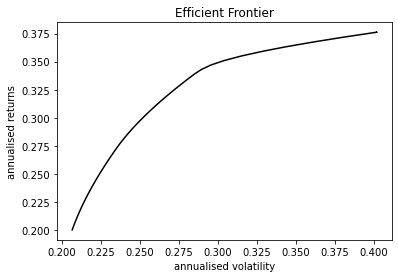

In [16]:
# calculate efficient frontier by minimizing risk for given levels of return
efficient_frontier = []
target_returns = np.linspace(0.2, 0.4, 50)
for target in target_returns:
    weights = minimize_volatility(expected_returns, cov_matrix, target).x
    returns, volatility = annualised_performance(weights, expected_returns, cov_matrix)
    efficient_frontier.append((returns, volatility))
    
# plot efficient frontier
plt.plot([x[1] for x in efficient_frontier], [y[0] for y in efficient_frontier], linestyle='-', color='black')
plt.title('Efficient Frontier')
plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')

### Backtesting: Minimizing Volatility
Theoretically, optimized weights that minimize volatility for a fixed return _r_ should theoretically do better in the test set than weights with a higher volatility but equal return _r_.

In [94]:
# test data
STARTING_AMOUNT = 100000


def calculate_returns(pct_change, weights):
    weighted_amount = weights * STARTING_AMOUNT
    return np.dot(weighted_amount, pct_change)


def comparison(num_assets, expected_returns, cov_matrix, pct_change, results_dict):
    # random weights
    random_weights = np.random.rand(num_assets)
    random_weights = random_weights / sum(random_weights)
    random_returns, random_volatility = annualised_performance(random_weights, expected_returns, cov_matrix)
    random_sharpe_ratio = sharpe_ratio(random_weights, expected_returns, cov_matrix)
    random_results = calculate_returns(pct_change, random_weights)
    results_dict['random_volatility'].append(random_volatility)
    results_dict['random_returns'].append(random_returns)
    results_dict['random_sharpe_ratio'].append(random_sharpe_ratio)
    results_dict['random_results'].append(random_results / STARTING_AMOUNT - 1)
    
    # optimal weights
    optimal_weights = minimize_volatility(expected_returns, cov_matrix, random_returns).x
    optimal_returns, optimal_volatility = annualised_performance(optimal_weights, expected_returns, cov_matrix)
    optimal_sharpe_ratio = sharpe_ratio(optimal_weights, expected_returns, cov_matrix)
    optimal_results = calculate_returns(pct_change, optimal_weights)
    results_dict['optimal_volatility'].append(optimal_volatility)
    results_dict['optimal_returns'].append(optimal_returns)
    results_dict['optimal_sharpe_ratio'].append(optimal_sharpe_ratio)
    results_dict['optimal_results'].append(optimal_results / STARTING_AMOUNT - 1)
    

def test(num_assets, test_df, train_df, num_iters):
    expected_returns, cov_matrix = extract_info(train_df)
    pct_change = np.exp(test_df.pct_change().apply(lambda x: np.log(1+x)).sum())
    results_dict = defaultdict(list)
    
    for i in range(num_iters):
        comparison(num_assets, expected_returns, cov_matrix, pct_change, results_dict)
    
    return pd.DataFrame.from_dict(results_dict)

In [92]:
BOLD_PREFIX = '\033[1m'
BOLD_SUFFIX = '\033[0m'
NUM_ITERS = 50
FORMATTING = 'Volatility: {:<10} Expected Returns: {:<10} Sharpe Ratio: {:<10} Results: {:<10}'


print(f'We started with {STARTING_AMOUNT}')

We started with 100000


Individual stocks: random weights
Volatility: 0.22393    Expected Returns: 0.16777    Sharpe Ratio: 0.67687    Results: 0.38947   
Individual stocks: optimal weights
Volatility: 0.20027    Expected Returns: 0.16777    Sharpe Ratio: 0.75682    Results: 0.52026   


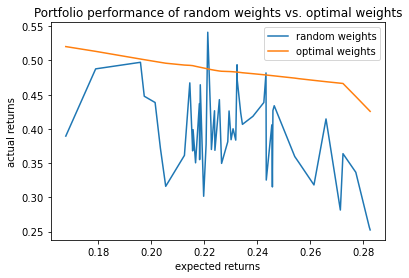

In [95]:
### INDIVIDUAL STOCKS
results_df1 = test(len(tickers1), df1_test, df1_train, NUM_ITERS)
results_df1 = results_df1.sort_values('random_returns')

# single result
result = results_df1.iloc[0,:]
print(f'{BOLD_PREFIX}Individual stocks: random weights{BOLD_SUFFIX}')
print(FORMATTING.format(round(result['random_volatility'], 5), round(result['random_returns'], 5), round(result['random_sharpe_ratio'], 5), round(result['random_results'], 5)))
print(f'{BOLD_PREFIX}Individual stocks: optimal weights{BOLD_SUFFIX}')
print(FORMATTING.format(round(result['optimal_volatility'], 5), round(result['optimal_returns'], 5), round(result['optimal_sharpe_ratio'], 5), round(result['optimal_results'], 5)))

# plot actual returns against expected returns
plt.plot(results_df1['random_returns'], results_df1['random_results'], label = "random weights")
plt.plot(results_df1['optimal_returns'], results_df1['optimal_results'], label = "optimal weights")
plt.ylabel('actual returns')
plt.xlabel('expected returns')
plt.title('Portfolio performance of random weights vs. optimal weights')
plt.legend()
plt.show()

ETFs: random weights
Volatility: 0.13293    Expected Returns: 0.08373    Sharpe Ratio: 0.50798    Results: 0.25406   
ETFs: optimal weights
Volatility: 0.11112    Expected Returns: 0.08373    Sharpe Ratio: 0.60768    Results: 0.26609   


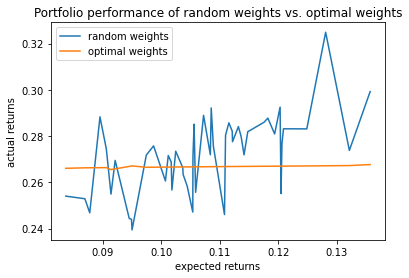

In [98]:
### ETFS
results_df2 = test(len(tickers2), df2_test, df2_train, NUM_ITERS)
results_df2 = results_df2.sort_values('random_returns')

# single result
result = results_df2.iloc[0,:]
print(f'{BOLD_PREFIX}ETFs: random weights{BOLD_SUFFIX}')
print(FORMATTING.format(round(result['random_volatility'], 5), round(result['random_returns'], 5), round(result['random_sharpe_ratio'], 5), round(result['random_results'], 5)))
print(f'{BOLD_PREFIX}ETFs: optimal weights{BOLD_SUFFIX}')
print(FORMATTING.format(round(result['optimal_volatility'], 5), round(result['optimal_returns'], 5), round(result['optimal_sharpe_ratio'], 5), round(result['optimal_results'], 5)))

# plot actual returns against expected returns
plt.plot(results_df2['random_returns'], results_df2['random_results'], label = "random weights")
plt.plot(results_df2['optimal_returns'], results_df2['optimal_results'], label = "optimal weights")
plt.ylabel('actual returns')
plt.xlabel('expected returns')
plt.title('Portfolio performance of random weights vs. optimal weights')
plt.legend()
plt.show()

In [ ]:
# plot sharpe ratio against actual returns
# plot volatility against actual returns

### References
https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/

https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f